In [1]:
!pip install parameters

In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd

import seaborn as sns
from __future__ import division
import time
from cvxpy import *

from distutils.log import error
import errno
import numpy as np
import pandas as pd
import time
from datetime import date
import cvxpy as cp

import parameters


%matplotlib inline

In [3]:
User_PV_Data = pd.read_csv('./Solar_Demand.csv')

# get_all_values gives a list of rows.


userdata = np.array(User_PV_Data.values)


print(User_PV_Data)

     Time  PV_Output  PV_Percentage  Demand_kW  Grid_Cost
0    0:00   0.000000            0.0       0.12       0.01
1    0:15   0.000000            0.0       0.12       0.01
2    0:30   0.000000            0.0       0.12       0.01
3    0:45   0.000000            0.0       0.12       0.01
4    1:00   0.000000            0.0       0.16       0.01
..    ...        ...            ...        ...        ...
92  23:00   0.000000            0.0       0.16       0.01
93  23:15   0.000000            0.0       0.16       0.01
94  23:30   0.000000            0.0       0.16       0.01
95  23:45   0.000000            0.0       0.16       0.01
96    NaN   5.972774            NaN        NaN        NaN

[97 rows x 5 columns]


In [6]:
prof=pd.Series(dtype='object')

prof.loc['Solar']=User_PV_Data.iloc[:96, 2]
prof.loc['Load']=User_PV_Data.iloc[:96, 3]
prof.loc['Price']=User_PV_Data.iloc[:96, 4]
prof.Load.shape[0]

96

ERROR! Session/line number was not unique in database. History logging moved to new session 492


In [8]:
'''This script contains the Islanded (islOptimizer()) and Grid-Connected (gcOptimizer()) optimization models and the optimization parameters.

Script Inputs: Solar, load, and price profiles for individual feeder. Parameters from parameters.py.
Script Outputs: Dispatch profile, PV capacity, battery capacity, system cost for individual feeder.

'''

# Islanded Optimizer: Capacity & dispatch for islanded system--------------------------------------------------------------------------------------
def islOptimizer(par,prof,k, C_min):
#     Linear optimization model for islanded microgrid using cvxpy. Model designed to run over k hour-long timesteps. 

#     Inputs:
#     1) par- Pandas series containing model parameters. Data stored in parameters.py
#     2) prof- Pandas series containing load (MW) and solar (% output) arrays. Each array should have k entries.
#     3) k- number of timesteps. Model is inteded to be hourly, therefore k corresponds to hours of islanded operation.

#     Output:
#     1) out- Pandas dataframe with k rows. Contains load, generation, and dispatch decisions alongside optimum PV and battery capacity.
    

    # Pre-optimization Data Validation
    if (prof.Load.shape[0]<k) or (prof.Load.min()<0):
        return None

    # Define Variables----------------------------------------------------------
    SOC = cp.Variable(k) # Battery SOC at step k (MWh)
    Bc = cp.Variable(k) # Battery charge at step k (MWh)
    Bd = cp.Variable(k) # Battery discharge at step k (MWh)
    Dpv = cp.Variable(k) # Curtailed PV production at step k (MWh)
    Dl = cp.Variable(k) # Cutailed load at step k (MWh)
    X = cp.Variable(1) # Solar capacity MW
    Y = cp.Variable(1) # Battery capacity MWh

    # Objective & Constraints---------------------------------------------------
    objective = cp.Minimize(X*par.Kpv + Y*par.Kb + cp.sum(Bd)*par.VCC)
    constraints = []

    # Load Balancing Contraints
    constraints += [X*prof.Solar + Bd + Dl == Bc + prof.Load + Dpv] # Load balance
    constraints += [0 <= Dl, Dl <= prof.Load] # Load curtailment range
    constraints += [cp.sum(Dl) <= cp.sum(prof.Load)*par.R] # Max load curtailment
    constraints += [0 <= Dpv, Dpv <= X*prof.Solar] # PV curtailment range

    # Battery Constraints
    constraints += [0 <= X, 0 <= Y] # Capacity range
    constraints += [0 <= SOC, SOC <= Y] # SOC range
    constraints += [0 <= Bc, Bc <= Y/4] # Charge rate range 
    constraints += [0 <= Bd, Bd <= Y/4] # Disharge rate range
    constraints += [SOC[0] == Y] # Inital SOC
    constraints += [SOC[k-1] == C_min] # Inital SOC
    constraints += [SOC[i+1] == SOC[i] + Bc[i]*par.nu - Bd[i]/par.nu for i in range(k-1)] # SOC over time

    opt = cp.Problem(objective, constraints)
    opt.solve(verbose=False,solver=cp.ECOS,feastol=10**-4)

    # Collect Outputs----------------------------------------------------------------
    out = pd.DataFrame(dtype='object')
    out.loc[:,'L'] = prof.Load
    out.loc[:,'SX'] = X.value*prof.Solar
    out.loc[:,'SOC'] = SOC.value
    out.loc[:,'Bc'] = Bc.value
    out.loc[:,'Bd'] = Bd.value
    out.loc[:,'Dpv'] = Dpv.value
    out.loc[:,'Dl'] = Dl.value
    out.loc[:,'X'] = X.value[0]
    out.loc[:,'Y'] = Y.value[0]
    
    out = out.round(2)
    
    print(X.value[0]*par.Kpv + Y.value[0]*par.Kb)
    return out


# Grid-Connected Optimizer: Capacity & dispatch for grid-connected operation------------------------------------------------
def GridOptimizer(par,prof, k = 96):

#     Linear optimization model for grid-connected microgrid using cvxpy. Model designed to run over k hour-long timesteps. 

#     Inputs:
#     1) par- Pandas series containing model parameters. Data stored in parameters.py
#     2) prof- Pandas series containing load (MW) and solar (% output) arrays. Each array should have k entries.
#     3) k- number of timesteps. Model is inteded to be hourly, therefore k corresponds to hours of grid-connected operation.

#     Output:
#     1) out- Pandas dataframe with k rows. Contains load, generation, and dispatch decisions alongside optimum PV and battery capacity  

    

    # Pre-optimization Data Validation
#     if (prof.Load.shape[0]<k) or (prof.Load.min()<0):
#         return None
    
    # Define Variables---------------------------------------------------------------------
    SOC = cp.Variable(k) # Battery SOC at step k (MWh)
    Bc = cp.Variable(k) # Battery charge at step k (MWh)
    Bd = cp.Variable(k) # Battery discharge at step k (MWh)
    Dl = cp.Variable(k) # Cutailed load at step k (MWh)
    Ge = cp.Variable(k) # Grid energy export at step k (MWh)
    Gi = cp.Variable(k) # Grid energy import at step k (MWh)
    X = cp.Variable(1) # Solar capacity MW
    Y = cp.Variable(1) # Battery capacity MWh

    # Objective & Constraints---------------------------------------------------------------
    objective = cp.Minimize(X*par.Kpv + Y*par.Kb + cp.sum(Bd)*par.VCC + Gi@prof.Price - Ge@prof.Price)
    constraints = []

    # Load Balancing Contraints
    constraints += [X*prof.Solar + Bd + Dl + Gi == Bc + prof.Load + Ge] # 0: Load balance
    constraints += [0 <= Dl, Dl <= prof.Load] # 1,2: Load curtailment range
    constraints += [cp.sum(Dl) <= cp.sum(prof.Load)*par.R] # 3: Max load curtailment

    # Grid Import and Export
    constraints += [0 <= Ge, Ge <= X*prof.Solar + Bd] # 4,5: Grid export range
    constraints += [0 <= Gi, Gi <= prof.Load + Bc] # 6,7: Grid import range 

    # Battery Charge/Discharge Constraints
    constraints += [0 <= X, 0 <= Y] # Capacity range
    constraints += [X <= 3, Y <= 3.5]
    constraints += [0 <= SOC, SOC <= Y] # SOC range
    constraints += [0 <= Bc, Bc <= Y/4] # Charge rate range 
    constraints += [0 <= Bd, Bd <= Y/4] # Disharge rate range
    constraints += [SOC[0] == Y] # Inital SOC
    constraints += [SOC[i+1] == SOC[i] + Bc[i]*par.nu - Bd[i]/par.nu for i in range(k-1)] # SOC over time

    opt = cp.Problem(objective, constraints)
    opt.solve(verbose=False)

    # Collect Outputs----------------------------------------------------------------
    out = pd.DataFrame(dtype='object')
    out.loc[:,'L'] = prof.Load
    out.loc[:,'P'] = prof.Price
    out.loc[:,'SX'] = X.value*prof.Solar
    out.loc[:,'SOC'] = SOC.value
    out.loc[:,'Bc'] = Bc.value
    out.loc[:,'Bd'] = Bd.value
    out.loc[:,'Gi'] = Gi.value
    out.loc[:,'Ge'] = Ge.value
    out.loc[:,'Dl'] = Dl.value
    out.loc[:,'X'] = X.value[0]
    out.loc[:,'Y'] = Y.value[0]
    out = out.round(2)
    return out



# Grid-Connected Optimizer (with options): Capacity & dispatch for grid-connected operation------------------------------------------------------------------------
def gc_options_Optimizer(par,prof,MinX,MinY,FixedCap=False):

#     Linear optimization model for grid-connected microgrid using cvxpy. Model designed to run over k hour-long timesteps. 

#     Inputs:
#     1) par- Pandas series containing model parameters. Data stored in parameters.py
#     2) prof- Pandas series containing load (MW) and solar (% output) arrays. Each array should have k entries.
#     3) k- number of timesteps. Model is inteded to be hourly, therefore k corresponds to hours of grid-connected operation.

#     Output:
#     1) out- Pandas dataframe with k rows. Contains load, generation, and dispatch decisions alongside optimum PV and battery capacity  
 
 # Timesteps
    k = 96

    # Pre-optimization Data Validation
    if (prof.Load.shape[0]<k) or (prof.Load.min()<0):
        return None
    
    # Define Variables---------------------------------------------------------------------
    SOC = cp.Variable(k) # Battery SOC at step k (MWh)
    Bc = cp.Variable(k) # Battery charge at step k (MWh)
    Bd = cp.Variable(k) # Battery discharge at step k (MWh)
    Dl = cp.Variable(k) # Cutailed load at step k (MWh)
    Ge = cp.Variable(k) # Grid energy export at step k (MWh)
    Gi = cp.Variable(k) # Grid energy import at step k (MWh)
    X = cp.Variable(1) # Solar capacity MW
    Y = cp.Variable(1) # Battery capacity MWh

    # Objective & Constraints---------------------------------------------------------------
    objective = cp.Minimize(X*par.Kpv + Y*par.Kb + cp.sum(Bd)*par.VCC + Gi@prof.Price - Ge@prof.Price)
    constraints = []

    # Load Balancing Contraints
    constraints += [X*prof.Solar + Bd + Dl + Gi == Bc + prof.Load + Ge] # 0: Load balance
    constraints += [0 <= Dl, Dl <= prof.Load] # 1,2: Load curtailment range
    constraints += [cp.sum(Dl) <= cp.sum(prof.Load)*par.R] # 3: Max load curtailment

    # Grid Import and Export
    constraints += [0 <= Ge, Ge <= X*prof.Solar + Bd] # 4,5: Grid export range
    constraints += [0 <= Gi, Gi <= prof.Load + Bc] # 6,7: Grid import range

    # Capacity Contraints
    if FixedCap == True:
        constraints += [X <= MinX, Y <= MinY] # 8,9: Maximum capacity = psps capacity
    else:
        constraints += [X <= 2*MinX, Y <= 2*MinY] # 8,9: Maximum capacity (feeder capacity)
    constraints += [MinX <= X, MinY <= Y] # 10,11: Minimum capacity    

    # Battery Charge/Discharge Constraints
    constraints += [0 <= SOC, SOC <= Y] # SOC range
    constraints += [0 <= Bc, Bc <= Y/4] # Charge rate range 
    constraints += [0 <= Bd, Bd <= Y/4] # Disharge rate range
    constraints += [SOC[0] == Y] # Inital SOC
    constraints += [SOC[i+1] == SOC[i] + Bc[i]*par.nu - Bd[i]/par.nu for i in range(k-1)] # SOC over time

    opt = cp.Problem(objective, constraints)
    opt.solve(verbose=False)

    # Collect Outputs----------------------------------------------------------------
    out = pd.DataFrame(dtype='object')
    out.loc[:,'L'] = prof.Load
    out.loc[:,'P'] = prof.Price
    out.loc[:,'SX'] = X.value*prof.Solar
    out.loc[:,'SOC'] = SOC.value
    out.loc[:,'Bc'] = Bc.value
    out.loc[:,'Bd'] = Bd.value
    out.loc[:,'Gi'] = Gi.value
    out.loc[:,'Ge'] = Ge.value
    out.loc[:,'Dl'] = Dl.value
    out.loc[:,'X'] = X.value[0]
    out.loc[:,'Y'] = Y.value[0]
    out = out.round(2)
    return out

# Parameters----------------------------------------------------------------------------------------------------------------------
par = pd.Series(dtype='object')
# DER Parameters
par.loc['Kpv'] = 1200000 # Solar capacity cost ($/MW)
par.loc['Kb'] = 400000 # Battery capacity cost ($/MWh)
par.loc['Ki'] = 300000 # Inverter capacity cost ($/MW)
par.loc['VCC'] = 750000 # Battery discharge cost ($/MWh)
par.loc['nu'] = 0.85 # Battery efficiency
par.loc['r'] =  0.004 # Real interest rate
par.loc['Lpv'] = 25 # Solar lifetime (yrs)
par.loc['Lb'] = 10 # Battery lifetime (yrs)
par.loc['Li'] = 10 # Inverter lifetime (yrs)
par.loc['OM'] = 12000 # O&M cost ($/MW-yr)
par.loc['R'] = 0.0 # Reliabiliy; fraction of load sheddable [0 or 0.01]
par.loc['Cpv'] = par.Kpv*par.r/(1-(1+par.r)**-par.Lpv) # Annualized solar capacity cost ($/MW-yr)
par.loc['Cb'] = par.Kb*par.r/(1-(1+par.r)**-par.Lb) # Annualized battery capacity cost ($/MW-yr)
par.loc['Ci'] = par.Ki*par.r/(1-(1+par.r)**-par.Li) # Annualized inverter capacity cost ($/MW-yr)


7899371.747135735


,L,SX,SOC,Bc,Bd,Dpv,Dl,X,Y
0,0.12,0.0,7.89,-0.0,0.12,-0.0,0.0,3.95,7.89
1,0.12,0.0,7.75,-0.0,0.12,-0.0,0.0,3.95,7.89
2,0.12,0.0,7.61,-0.0,0.12,-0.0,0.0,3.95,7.89
3,0.12,0.0,7.46,-0.0,0.12,-0.0,0.0,3.95,7.89
4,0.16,0.0,7.32,-0.0,0.16,-0.0,0.0,3.95,7.89
...,...,...,...,...,...,...,...,...,...
91,0.20,0.0,4.80,-0.0,0.20,-0.0,0.0,3.95,7.89
92,0.16,0.0,4.56,-0.0,0.16,-0.0,0.0,3.95,7.89
93,0.16,0.0,4.38,-0.0,0.16,-0.0,0.0,3.95,7.89
94,0.16,0.0,4.19,-0.0,0.16,-0.0,0.0,3.95,7.89


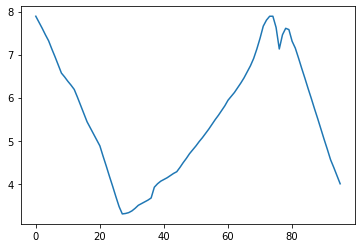

In [11]:
#islanded system optimization for  24 hour period

k=96
C_min=4
out=islOptimizer(par,prof,k,C_min)

plt.plot(out.SOC)

out

In [ ]:

gc_options_Optimizer(par,prof,3,3.5,FixedCap=False)

In [ ]:
out1=GridOptimizer(par,prof, k = 96)
out1

In [ ]:
plt.plot(out1.SOC)